In [363]:
import pandas as pd 
import numpy as np
import calendar
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import osmnx as ox
from folium.plugins import HeatMap
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange,Legend
from bokeh.palettes import Category20
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

output_notebook()

Loading BokehJS ...

In [350]:
df = pd.read_csv("/Users/rasmusblirupjensen/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2019.csv")
codes = pd.read_excel("/Users/rasmusblirupjensen/Downloads/ParkingViolationCodes_Nov_2018.xlsx")
df = df.sample(frac=0.20)

/Users/rasmusblirupjensen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,20,22,23,29,30,31,32,36,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [351]:
df = df.rename(columns={"Violation Code": "Code"})
df['Date']=pd.to_datetime(df["Issue Date"], format='%m/%d/%Y', errors='coerce')
# Weekday name & number
df["Day Name"] = df["Date"].apply(lambda x: x.day_name())
df["Day Number"] =  df["Date"].apply(lambda x: x.dayofweek)
#Monthly
df["Month Number"] =  df["Date"].apply(lambda x: x.month)
df.dropna(subset= ["Violation Time"], inplace = True)

#Sheet with the violation descriptions
codes = codes.rename(columns={"VIOLATION CODE": "Code"})
#Adding the violation discription to the dataframe
result =  df.merge(codes, on='Code', how='left')


In [352]:
df.head()

Summons Number Plate ID Registration State Plate Type  Issue Date  \
8391664      8644589854  56365MJ                 NY        COM  03/14/2019   
6744182      8689569455   FS0568                 WA        PAS  01/17/2019   
4336141      8677673817  HLX1698                 NY        PAS  11/24/2018   
5834680      8704359240  18055JZ                 NY        COM  12/07/2018   
9037698      8731908755  JEB2920                 NY        PAS  04/02/2019   

         Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
8391664    47               VAN        ISUZU              T         10210   
6744182    40              SUBN        ME/BE              T         34010   
4336141    21              4DSD        HONDA              T         19340   
5834680    69               VAN         FORD              T         18150   
9037698    38              4DSD        HONDA              T         51890   

         ...  Feet From Curb  Violation Post Code  Violation Description  \
8391664  ...               0                   12                    NaN   
6744182  ...               2                   33                    NaN   
4336141  ...               0                   37                    NaN   
5834680  ...               0                   15                    NaN   
9037698  ...               0                   45                    NaN   

         No Standing or Stopping Violation  Hydrant Violation  \
8391664                                NaN                NaN   
6744182                                NaN                NaN   
4336141                                NaN                NaN   
5834680                                NaN                NaN   
9037698                                NaN                NaN   

         Double Parking Violation       Date  Day Name Day Number Month Number  
8391664                       NaN 2019-03-14  Thursday          3            3  
6744182                       NaN 2019-01-17  Thursday          3            1  
4336141                       NaN 2018-11-24  Saturday          5           11  
5834680                       NaN 2018-12-07    Friday          4           12  
9037698                       NaN 2019-04-02   Tuesday          1            4  

[5 rows x 47 columns]

In [443]:
df.columns

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation', 'Date', 'Day Name', 'Day Number',
       'Mo

### Information regarding the Dataset

In [455]:
print("Number of issuing squads:", len(df["Issuer Command"].unique()))
print("Number of issuing squads:", len(df["Issuer Squad"].unique()))
print("Number of issuing guards:", len(df["Issuer Code"].unique()))
print(50*"-")
print("Number of violation districts:", len(df["Violation Precinct"].unique()))


Number of issuing squads: 885
Number of issuing squads: 50
Number of issuing guards: 14181
--------------------------------------------------
Number of violations districts: 139


### Top 20 Issuing Guards

In [483]:
print("Top 15 most used stations")
print(61*"-")
top_issuer = df["Issuer Command"].value_counts()[:20]
top = top_issuer.index.to_list()
top_issuer

Top 15 most used stations
-------------------------------------------------------------


T103    200926
T302    178676
T401    162212
T201    157808
T402    143390
T301    124484
T101     54641
T105     54100
T102     47504
T106     43284
MTTF     21629
T303     19549
0401     15773
T802     14967
T801     12599
T800     10399
T108      5875
T803      4395
T501      3662
KS07      3649
Name: Issuer Command, dtype: int64

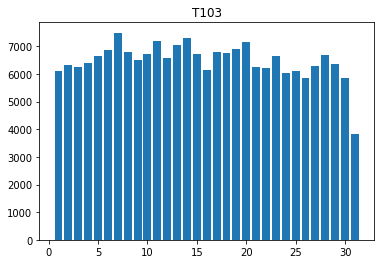

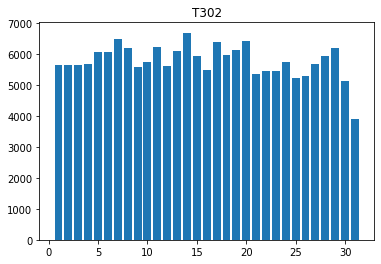

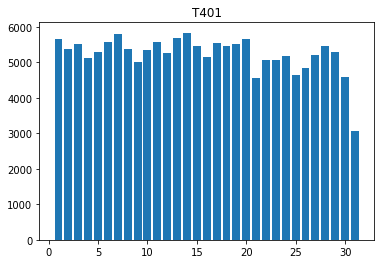

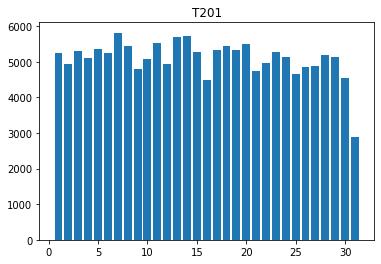

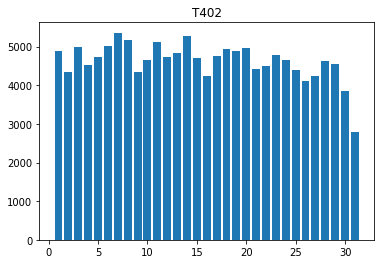

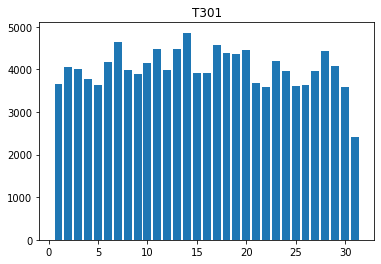

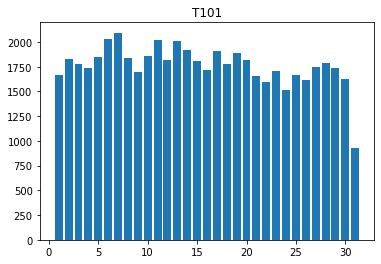

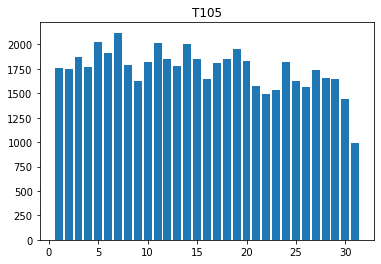

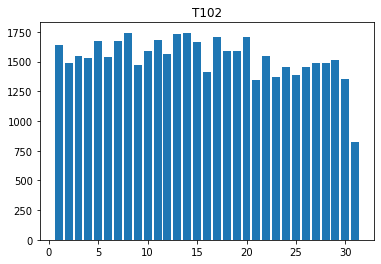

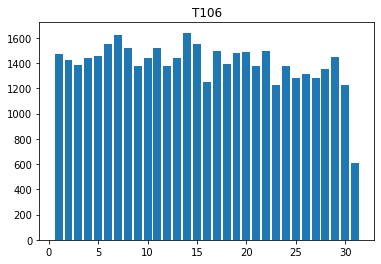

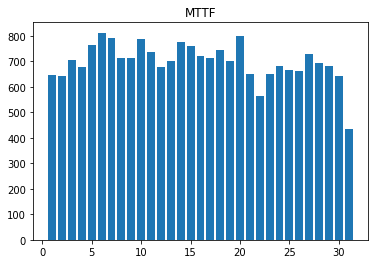

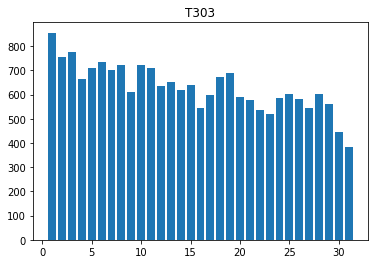

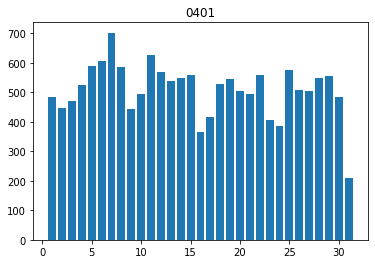

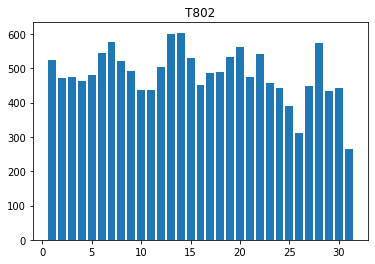

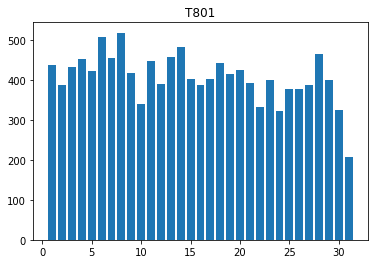

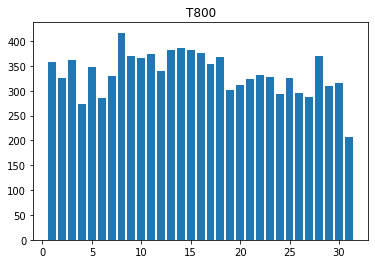

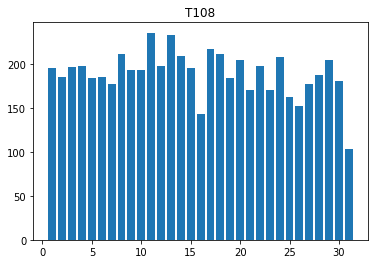

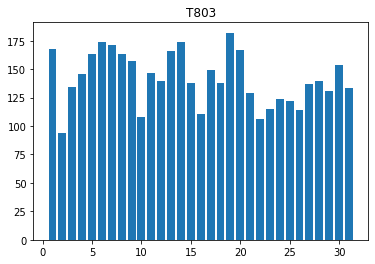

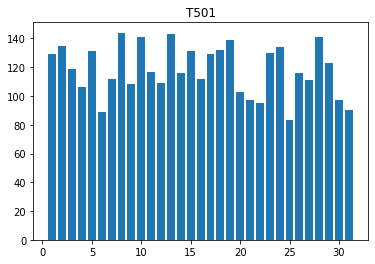

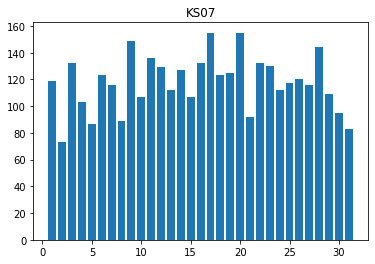

In [484]:
for i in top:
    fine = df.loc[df["Issuer Command"] == i]
    a = fine["Date"].dt.day.value_counts()
    b = a.sort_index()
    c = b.to_list()
    d = b.index.to_list()
    plt.bar(d, c)
    plt.title(i)
    plt.show()

In [353]:
## converting the Violation Time to datetime 
def time(xx):
    time = []
    for x in xx:
        x = str(x)
        if x[-1:] == "P":
            if x[:2] >= "12":
                new_x = "00"
                second = x[2:4]
                new_time = new_x+":"+str(second)+":"+"00"    
                time.append(new_time)
            else:
                first = int(x[:2])+12
                second = x[2:4]
                new_time = str(first)+":"+str(second)+":"+"00"   
                time.append(new_time)
        else:
            first = x[:2]
            second = x[2:4]
            new_time = str(first)+":"+str(second)+":"+"00"    
            time.append(new_time)
    return time


In [354]:
result["Time"] = time(result['Violation Time'])
result["Time"] = pd.to_datetime(result["Time"], format = '%H:%M:%S',  errors='coerce' )
result["Hour"] = result["Time"].dt.hour
result.dropna(subset= ["Hour"], inplace = True)

In [368]:
#Top 5 most violtated parkings crimes
topfines = result["VIOLATION DESCRIPTION"].value_counts()[:10]
topfines

NO PARKING-STREET CLEANING        360529
FAIL TO DSPLY MUNI METER RECPT    232807
PHTO SCHOOL ZN SPEED VIOLATION    219642
NO STANDING-DAY/TIME LIMITS       202662
NO PARKING-DAY/TIME LIMITS        158711
DOUBLE PARKING                    118173
FIRE HYDRANT                      110912
INSP. STICKER-EXPIRED/MISSING     110278
EXPIRED MUNI METER                 97231
FAILURE TO STOP AT RED LIGHT       94397
Name: VIOLATION DESCRIPTION, dtype: int64

In [369]:
fines = topfines.index.to_list()
df = result.loc[result['VIOLATION DESCRIPTION'].isin(fines)]

In [370]:
#Top 5 crimes % size of total set 
print(len(df)/len(result)*100 ,"%")

74.35650916276538 %


In [371]:
#Length and number of variables in the dataset 
print("Number of rows: {}  \nNumber of Variables: {}" .format(df.shape[0], str(df.shape[1])))

Number of rows: 1705342  
Number of Variables: 52


In [372]:
df.head()

Summons Number Plate ID Registration State Plate Type  Issue Date  Code  \
1      8689569455   FS0568                 WA        PAS  01/17/2019    40   
2      8677673817  HLX1698                 NY        PAS  11/24/2018    21   
4      8731908755  JEB2920                 NY        PAS  04/02/2019    38   
8      8743402835    1F26A                 NY        OMT  05/25/2019    38   
9      8622727634   NUF229                 WV        PAS  11/04/2018    40   

  Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  ...  \
1              SUBN        ME/BE              T         34010  ...   
2              4DSD        HONDA              T         19340  ...   
4              4DSD        HONDA              T         51890  ...   
8              SUBN        TOYOT              T         28830  ...   
9              SUBN        MAZDA              T         36190  ...   

   Double Parking Violation       Date  Day Name  Day Number  Month Number  \
1                       NaN 2019-01-17  Thursday           3             1   
2                       NaN 2018-11-24  Saturday           5            11   
4                       NaN 2019-04-02   Tuesday           1             4   
8                       NaN 2019-05-25  Saturday           5             5   
9                       NaN 2018-11-04    Sunday           6            11   

            VIOLATION DESCRIPTION  \
1                    FIRE HYDRANT   
2      NO PARKING-STREET CLEANING   
4  FAIL TO DSPLY MUNI METER RECPT   
8  FAIL TO DSPLY MUNI METER RECPT   
9                    FIRE HYDRANT   

   Manhattan  96th St. & below\n(Fine Amount $)  \
1                                         115.0   
2                                          65.0   
4                                          65.0   
8                                          65.0   
9                                         115.0   

  All Other Areas\n(Fine Amount $)                Time  Hour  
1                            115.0 1900-01-01 13:44:00  13.0  
2                             45.0 1900-01-01 08:36:00   8.0  
4                             35.0 1900-01-01 11:18:00  11.0  
8                             35.0 1900-01-01 13:32:00  13.0  
9                            115.0 1900-01-01 07:55:00   7.0  

[5 rows x 52 columns]

In [439]:
def bokeh(df,x):
    bokeh = df[df["VIOLATION DESCRIPTION"].isin(fines)] #Reducing the dataframe only to obtain the forcuscrimes
    station = bokeh.groupby(df[x])["VIOLATION DESCRIPTION"].value_counts().unstack()
    station.reset_index(level=0, inplace=True) # creating a new index, so hour becomes a column. 
    
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    source = ColumnDataSource(station)
    
    hours = [] # empty list to store the string converted hours
    for i in range(len(df[x].unique())):
        hours.append(str(i))
    
    p = figure(x_range = FactorRange(factors=hours),plot_height=500, plot_width= 1200, toolbar_location=None, title="Distibution of # of fines for top 10 violations pr. {}".format(x))
    bar ={}
    items = [] 
    for indx,i in enumerate(fines):
        bar[i] = p.vbar(x=x, width=0.5,  top=i, source = source, muted_alpha =0.09, alpha=3, muted_color=Category20[15][indx] ,color=Category20[15][indx]) 
        items.append((i, [bar[i]])) #the dictionary is appended to the items list, to the respective category.  
        
    legend = Legend(items=items, location=(0,50)) #Legend and location is configured
    p.add_layout(legend, "left") #Adding the legend outisde the plot. 
    p.xaxis.axis_label = x #Setting x-axis title
    p.yaxis.axis_label = "# of fines" #Setting y-axis title
    p.x_range.range_padding = 0.04 # 
    p.legend.click_policy="mute" #mute is chossen, becuase this enables one to see all of the different categories partily if not chosen, instead of hiding them. 
    show(p) 

In [440]:
bokeh(df,"Hour")
bokeh(df,"Month Number")
bokeh(df, "Day Number")

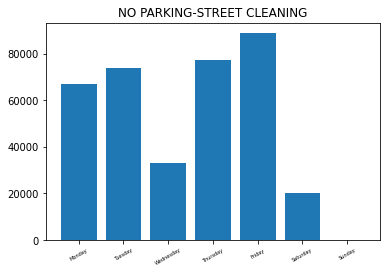

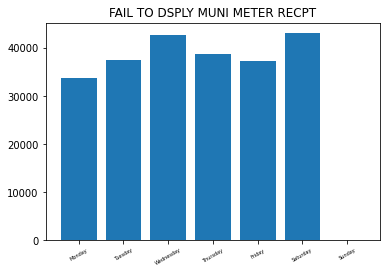

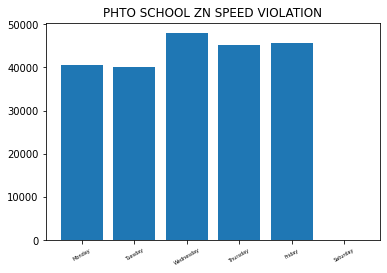

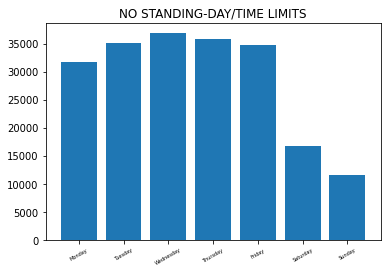

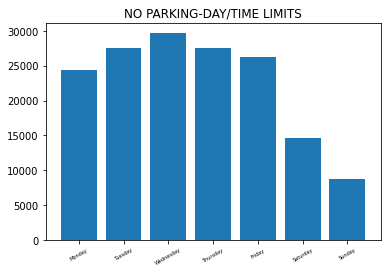

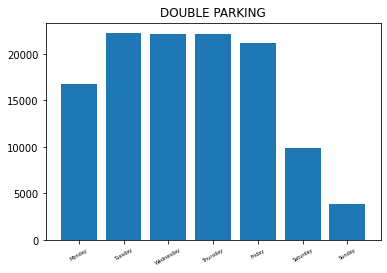

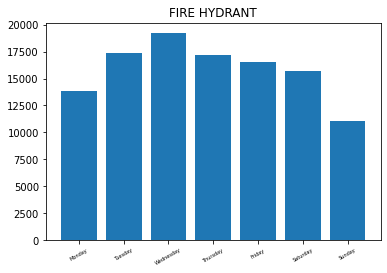

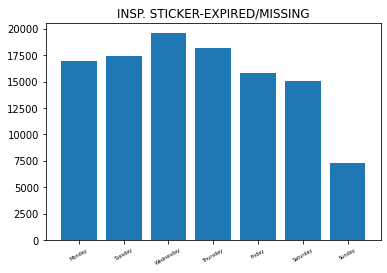

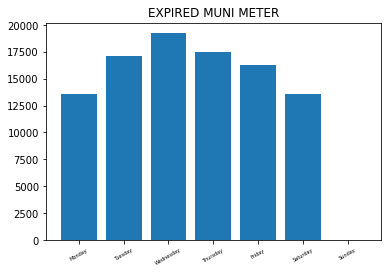

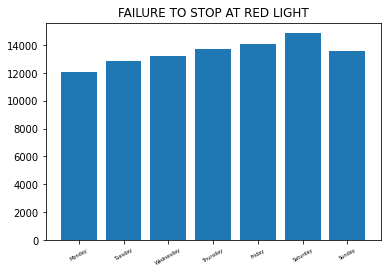

In [405]:
for i in fines:
    fine = df.loc[df["VIOLATION DESCRIPTION"] == i]
    days = dict(zip(fine["Day Number"], fine["Day Name"]))
    count_weekdays = fine["Day Number"].value_counts()
    count_weekdays = count_weekdays.sort_index()
    days_count = count_weekdays.to_list()
    days_num = count_weekdays.index.to_list()
    day_name = list(map(days.get,days_num))
    plt.bar(days_num, days_count)
    plt.title(i)
    plt.xticks(days_num, day_name, fontsize=5, rotation=30)
    plt.show()

In [ ]:
for i in fines:
    fine = df.loc[df["VIOLATION DESCRIPTION"] == i]
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    count_months = fine["Month Number"].value_counts()
    count_weekdays = count_months.sort_index()
    month_count = count_months.to_list()
    month_num = count_months.index.to_list()
    month_name = list(map(monthDict.get,month_num))
    plt.bar(month_num, month_count)
    plt.title(i)
    plt.xticks(month_num, month_name, fontsize=5, rotation=30)
    plt.show()

#Data Properties 
In the dataset, there is geolocation attributes, such as strees names, house numbers, states codes etc. Next there is description of the different vehicles. There is an issue date which tells us when the violation has happened, and a timestamp for the violation. 

In [73]:
#result.shape
#result["Adress"] = result["Street Name"] + " " + str(result["House Number"])

In [17]:
#result_new.to_csv("PARKING2019.csv")

In [75]:
#result.columns

In [25]:
a= "0918A"

In [39]:
result_new['Issuer Squad'].unique()

array([nan, 'N', 'A', 'J', 'F', 'B', 'D', 'T', 'S', 'L', 'W', 0.0, 'Q',
       'C', '0000', 'V', 'K', 'I', 'G', 'X', 'H', 'E', 'Y', 'M', 'R', 'O',
       'EE', 'AA', 'P', 'B2', 'FF', 'DD', 'HH', 'CC', 'A2', 'GG', 'BB',
       'U', 'YA', 'II', 'X1', 'YP', 'X2', 'D2', 'GA', 'Z', 'AB', 'FA',
       'GP', 'C2', 'A1'], dtype=object)